In [ ]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [ ]:
#载入数据
data_train = pd.read_csv('./train_data.csv')
data_test = pd.read_csv('./test_a.csv')
data_all = pd.concat([data_train, data_test], ignore_index=True)
fea_cols = [col for col in data_train.columns]

In [ ]:
data_train.head(5)
data_test.head(5)
# np.equal(data_train.columns, data_test.columns)
# print(fea_cols)

## 异常值处理

In [ ]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200]
    train = train[(train.tradeMoney <=16000) & (train.tradeMoney >=700)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace=True)
#     sns.regplot(x=data_train['area'],y=data_train['tradeMoney'])
#     plt.show()
    return train  
#数据集异常值处理
data_train = dropData(data_train)
print('len(data_train):', len(data_train))

## 缺失值处理、数据变换

In [ ]:
def preprocessingData(data):
    # 填充缺失值
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 转换object类型数据
    columns = ['houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'plate']  # 'rentType', 'houseType',
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    # 将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值填充为平均值
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')

    # 分割交易时间
    def month(x):
        month = int(x.split('/')[1])
        return month
    def day(x):
        day = int(x.split('/')[2])
        return day
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
    # 去掉部分特征：city=SH, ID唯一, 
    data.drop('city', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    return data

data_train = preprocessingData(data_train)
drop_ID = data_train.drop('ID', axis=1, inplace=True)
# data_train
data_test = preprocessingData(data_test)
# data_test

In [ ]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    data['region'] = LabelEncoder().fit_transform(data['region'])
    return data

data_train = cleanData(data_train)
# data_train
data_test['region'] = LabelEncoder().fit_transform(data_test['region'])
# data_test

In [ ]:
def houseType(data):
    # 特征拆分
    # 将houseType转为'Room'，'Hall'，'Bath'
    def Room(x):
        Room = int(x.split('室')[0])
        return Room
    def Hall(x):
        Hall = int(x.split("室")[1].split("厅")[0])
        return Hall
    def Bath(x):
        Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
        return Bath

    data['Room'] = data['houseType'].apply(lambda x: Room(x))
    data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
    data['Bath'] = data['houseType'].apply(lambda x: Bath(x))
#     data['transportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / data['busStationNum'].mean()
    # 交叉生成特征:特征之间交叉+ - * / 
    data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
                                                          
    return data

data_train = houseType(data_train)
# data_train
data_test = houseType(data_test)
# data_test

In [ ]:
def fill(data):
    # 填充租房类型
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'
    # print(data.loc[(data['rentType']=='未知方式')&(data['Room_Bath']>1),'rentType'])
    data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
    # data.loc[(data['rentType']=='未知方式')&(data['area']>60),'rentType']='合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'
    return data

data_train = fill(data_train)
# data_train

In [ ]:
# 特征合并
def newfeature(data):
    # 合并部分配套设施特征
    data['transportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / data['busStationNum'].mean()
    data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data['schoolNum'].mean() \
                            + data['privateSchoolNum'] / data['privateSchoolNum'].mean()
    data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + data['drugStoreNum'] / data['drugStoreNum'].mean()
    data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + data['superMarketNum'] / data['superMarketNum'].mean()
    data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \
                       data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()

    data.drop(['subwayStationNum', 'busStationNum',
               'interSchoolNum', 'schoolNum', 'privateSchoolNum',
               'hospitalNum', 'drugStoreNum', 'mallNum', 'superMarketNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum'],
              axis=1, inplace=True)
    # 提升0.0005
#     data['houseType_1sumcsu']=data['Bath'].map(lambda x:str(x))+data['month'].map(lambda x:str(x))
#     data['houseType_2sumcsu']=data['Bath'].map(lambda x:str(x))+data['communityName']
#     data['houseType_3sumcsu']=data['Bath'].map(lambda x:str(x))+data['plate']
    
    data.drop('houseType', axis=1, inplace=True)
#     data.drop('tradeTime', axis=1, inplace=True)
    
    data["area"] = data["area"].astype(int)

    # categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName','region', 'plate']
#     categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate','cluster']

    return data

data_train = newfeature(data_train)
# data_train
data_test = newfeature(data_test)
# data_test

In [ ]:
def encoder(data):
    # 特征编码
    data['rentType'] = LabelEncoder().fit_transform(data['rentType'])
    return data

data_train = encoder(data_train)
data_test = encoder(data_test)
# data_train
# data_test

In [ ]:
#聚类
def cluster(train, test):
    from sklearn.mixture import GaussianMixture

    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    col = ['totalFloor',
           'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',

           'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
           'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',

           'landTotalPrice', 'landMeanPrice', 'totalWorkers',
           'newWorkers', 'residentPopulation', 'lookNum',
           'transportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']

    # EM
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    data['cluster']= pd.DataFrame(gmm.fit_predict(data[col]))


    col1 = ['totalFloor','houseDecoration', 'communityName', 'region', 'plate', 'buildYear']
    col2 = ['tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
            'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
            'landTotalPrice', 'landMeanPrice', 'totalWorkers',
            'newWorkers', 'residentPopulation', 'lookNum',
            'transportNum',
            'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']
    for feature1 in col1:
        for feature2 in col2:
        
            temp = data.groupby(['cluster',feature1])[feature2].agg('mean').reset_index(name=feature2+'_'+feature1+'_cluster_mean')
            temp.fillna(0, inplace=True)
            
            data = data.merge(temp, on=['cluster', feature1], how='left')
    
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    
    return new_train, new_test

data_train, data_test = cluster(data_train, data_test)
data_test.drop('tradeMoney', axis=1, inplace=True)


In [ ]:
#groupby生成统计特征：mean,std等
def groupby(train, test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
#     columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
#     for feature in columns:
#         data[feature] = LabelEncoder().fit_transform(data[feature])

    temp = data.groupby('communityName')['area'].agg({'com_area_mean': 'mean', 'com_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
    
    data['price_per_area'] = data.tradeMeanPrice / data.area * 100
    temp = data.groupby('communityName')['price_per_area'].agg({'comm_price_mean': 'mean', 'comm_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')

    temp = data.groupby('plate')['price_per_area'].agg({'plate_price_mean': 'mean', 'plate_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    data.drop('price_per_area', axis=1, inplace=True)

    temp = data.groupby('plate')['area'].agg({'plate_area_mean': 'mean', 'plate_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    
#     temp = data.groupby(['plate'])['buildYear'].agg({'plate_year_mean': 'mean', 'plate_year_std': 'std'})
#     data = data.merge(temp, on='plate', how='left')
#     data.plate_year_mean = data.plate_year_mean.astype('int')
#     data['comm_plate_year_diff'] = data.buildYear - data.plate_year_mean
#     data.drop('plate_year_mean', axis=1, inplace=True)

    temp = data.groupby('plate')['transportNum'].agg('sum').reset_index(name='plate_trainsportNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['transportNum'].agg('sum').reset_index(name='com_trainsportNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['trainsportNum_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                           data['com_trainsportNum'], data['plate_trainsportNum']))
    data = data.drop(['com_trainsportNum', 'plate_trainsportNum'], axis=1)

    temp = data.groupby('plate')['all_SchoolNum'].agg('sum').reset_index(name='plate_all_SchoolNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['all_SchoolNum'].agg('sum').reset_index(name='com_all_SchoolNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data = data.drop(['com_all_SchoolNum', 'plate_all_SchoolNum'], axis=1)

    temp = data.groupby(['communityName', 'plate'])['all_mall'].agg('sum').reset_index(name='com_all_mall')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')

    temp = data.groupby('plate')['otherNum'].agg('sum').reset_index(name='plate_otherNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['otherNum'].agg('sum').reset_index(name='com_otherNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['other_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                   data['com_otherNum'], data['plate_otherNum']))
    data = data.drop(['com_otherNum', 'plate_otherNum'], axis=1)

    temp = data.groupby(['month', 'communityName']).size().reset_index(name='communityName_saleNum')
    data = data.merge(temp, on=['month', 'communityName'], how='left')
    temp = data.groupby(['month', 'plate']).size().reset_index(name='plate_saleNum')
    data = data.merge(temp, on=['month', 'plate'], how='left')

    data['sale_ratio'] = round((data.communityName_saleNum + 1) / (data.plate_saleNum + 1), 3)
    data['sale_newworker_differ'] = 3 * data.plate_saleNum - data.newWorkers
    data.drop(['communityName_saleNum', 'plate_saleNum'], axis=1, inplace=True)

    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    return new_train, new_test

data_train, data_test = groupby(data_train, data_test)
data_train.drop('ID', axis=1, inplace=True)
data_test.drop('tradeMoney', axis=1, inplace=True)
# data_train
# data_test

In [ ]:
# 过大量级值取log平滑（针对线性模型有效）
big_num_cols = ['totalTradeMoney','totalTradeArea','tradeMeanPrice','totalNewTradeMoney', 'totalNewTradeArea',
                'tradeNewMeanPrice','remainNewNum', 'supplyNewNum', 'supplyLandArea',
                'tradeLandArea','landTotalPrice','landMeanPrice','totalWorkers','newWorkers',
                'residentPopulation','pv','uv']
for col in big_num_cols:
        data_train[col] = data_train[col].map(lambda x: np.log1p(x))
        data_test[col] = data_test[col].map(lambda x: np.log1p(x))
        


In [ ]:
target_train = data_train['tradeMoney'].tolist().reshape(1, -1)
# train = data_train.drop('tradeMoney', axis=1, inplace=True)
train = data_train['pv'].tolist().reshape(1, -1)
target_train
train
test = data_test
#对比特征工程前后线性模型结果情况
test = test.fillna(0)
# Lasso回归
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(train, target_train)
#预测测试集和训练集结果
y_pred_train = lasso.predict(train)
y_pred_test = lasso.predict(test)
#对比结果
from sklearn.metrics import r2_score
score_train = r2_score(y_pred_train, target_train)
print("训练集结果：",score_train)
score_test = r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

## 特征选择

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
# 训练随机森林模型，并通过feature_importances_属性获取每个特征的重要性分数。rf = RandomForestRegressor()
train = data_train.drop('tradeMoney', axis=1)
train = train.fillna(0)
y_pred = data_train['tradeMoney']
rf.fit(train, y_pred)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), data_train.columns), reverse=True))

In [ ]:
def drop_feature(data):
    drop_feature = ['rentType', 'newWorkers', 'tradeLandNum', 'tradeLandArea', 'supplyLandArea', 'region', 'landMeanPrice', 'supplyLandNum', 'landTotalPrice']
    for i in drop_feature:
        data.drop(i, axis=1)
    return data

data_train = drop_feature(data_train)
data_test = drop_feature(data_test)

In [ ]:
data_train.to_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/train_data(featured).csv')
# y_pred = data['tradeMoney']
# data.drop('tradeMoney', axis=1, inplace=True)
# data.to_csv('./train_data(featured_without_tradeMoney).csv')

data_test.to_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/test_a(cleared).csv')

In [ ]:
train = pd.read_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/train_data(featured).csv', index_col=0)
test = pd.read_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/test_a(cleared).csv', index_col=0)
# test = pd.read_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/test_a.csv')
# train.columns
# test.columns

In [ ]:
train_result = train['tradeMoney']
train_data = train.drop(['tradeMoney'],axis=1)
test_data = test.drop(['ID'],axis=1)
test_id = test.loc[:,'ID']

# xbox
X_train, X_test, Y_train, Y_test = train_test_split(train_data, train_result, test_size=0.1, random_state=2333)

xgb_val = xgb.DMatrix(X_test, label=Y_test)
xgb_train = xgb.DMatrix(X_train, label=Y_train)
xgb_test = xgb.DMatrix(test_data)
# xgbooster
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',  # 多分类的问题
    'n_estimators': 2200,
    'gamma': 0.0468,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 3,  # 构建树的深度，越大越容易过拟合
    "reg_alpha": 0.4640,
    'lambda': 7,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.5213,  # 随机采样训练样本
    'colsample_bytree': 0.4603,  # 生成树时进行的列采样
    'colsample_bylevel': 0.7,
    'min_child_weight': 2,
    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
    # ，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
    'silent': 1,  # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.05,  # 如同学习率  0.007
    'seed': 7,
    'reg_lambda': 0.8571
}

plst = list(params.items())
num_rounds = 10000  # 迭代次数
watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]

# 训练模型并保存
# early_stopping_rounds 当设置的迭代次数较大时，early_stopping_rounds 可在一定的迭代次数内准确率没有提升就停止训练
model = xgb.train(plst, xgb_train, num_rounds, watchlist, early_stopping_rounds=300, verbose_eval=50)
model.save_model('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/xgb.pth')  # 用于存储训练出的模型
print("模型训练完成")

print("训练完毕，开始预测")
test_result = model.predict(xgb_test, ntree_limit=model.best_ntree_limit)

data_df = pd.DataFrame(test_result)
filename = '/home/cc/holdshy/XJQ/数据竞赛（房租预测）/xgb_results.csv'
data_df.to_csv(filename, encoding='utf-8')


In [ ]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=2, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=True,
                             random_state=7, nthread=-1)
xgb_reg.fit(train_data, train_result)
Y_pred = xgb_reg.predict(test_data)

sub = pd.DataFrame({
    'id':test_id,
    'price':Y_pred
})
sub.to_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/XGBRegressor.csv',index=False)    #baseline：2.554


<img src="https://img-blog.csdnimg.cn/20190712170129921.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM5NzU2NzE5,size_16,color_FFFFFF,t_70" width=600 heigth=400 >

-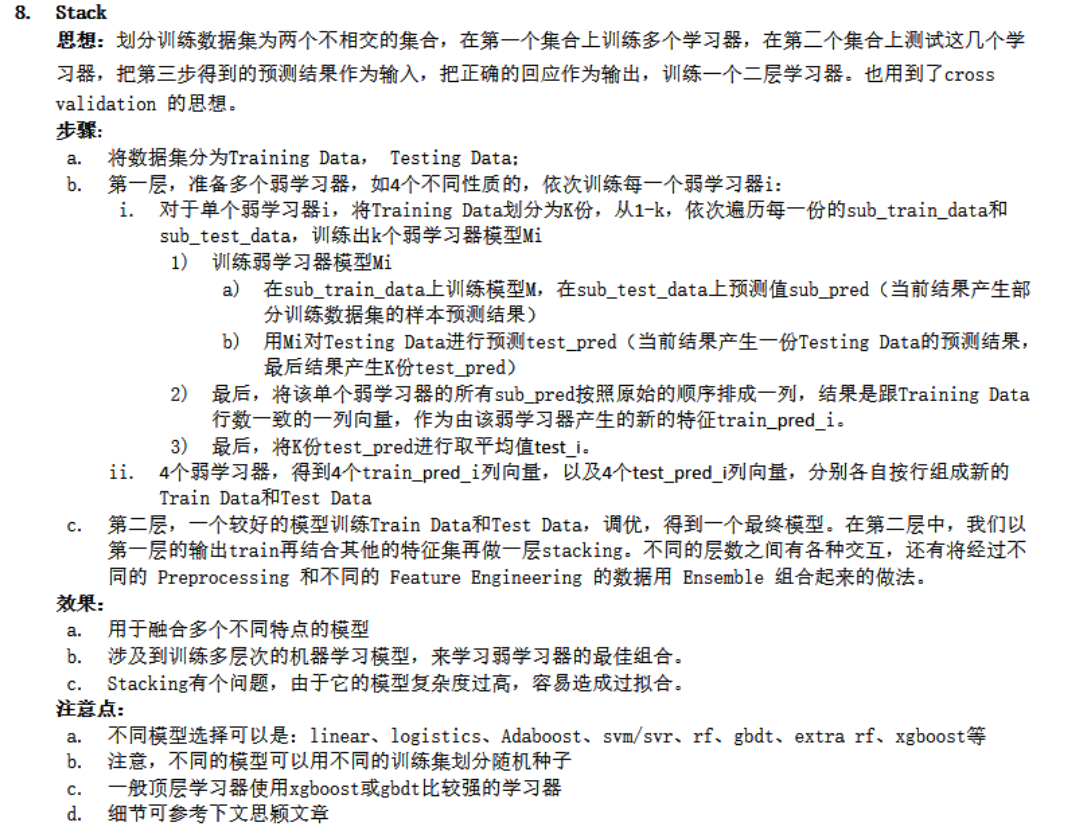

In [9]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/train_data(featured).csv', index_col=0)
test = pd.read_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/test_a(cleared).csv', index_col=0)
# train['tradeMoney']

In [3]:
# =========================model begin =========================================================== #
y_train = train['tradeMoney']
train = train.drop(['tradeMoney'],axis=1)
test_ID = test['ID']
test = test.drop(['ID'],axis=1)

n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    mse = np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return mse

kfolds = KFold(n_splits=n_folds, shuffle=True, random_state=42)
alph = [0.01, 0.001, 0.0001, 0.0002, 0.0004, 0.0008, 0.002, 0.004, 0.008, 1, 2, 4, 6, 8, 10, 12]
alph2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alph, cv=kfolds, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=alph, l1_ratio=.9, cv=kfolds, random_state=3))
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alph2, cv=kfolds))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=2, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=True,
                             random_state=7, nthread=-1)

model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

stacked_averaged_models = StackingCVRegressor(regressors=(ENet, GBoost, KRR),
                                              meta_regressor=lasso,
                                              use_features_in_secondary=True)

# stacked_averaged_models = StackingCVRegressor(regressors=(ridge, lasso, ENet, GBoost, model_xgb, model_lgb),
#                                               meta_regressor=model_lgb,
#                                               use_features_in_secondary=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# lasso.fit(train, y_train)
# lasso_train_pred = lasso.predict(train)
# lasso_pred = np.expm1(lasso.predict(test))

In [5]:
# 下一步，更改融合方式
# model_gboost = GradientBoostingRegressor
GBoost.fit(train, y_train)
GBoost_train_pred = GBoost.predict(train)
GBT_feature = GBoost.feature_importances_
gbt_out = np.argsort(GBT_feature)
print('GBoost RMSLE:')
print(rmsle(y_train, GBoost_train_pred))

# model_xgb = xgb.XGBRegressor
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_importance = model_xgb.feature_importances_
xgb_out = np.argsort(xgb_importance)
print('XGBoost RMSLE:')
print(rmsle(y_train, xgb_train_pred))

# model_lgb = lgb.LGBMRegressor
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
# save all models feature importance and drop the bad feature
# 给特征排序，然后删除无用特征
# lgb.plot_importance(model_lgb, max_num_features=30)
# plt.show()
booster = model_lgb.booster_
lgb_importance = booster.feature_importance(importance_type='split')
lgb_out = np.argsort(lgb_importance)
print('LightGBM RMSLE:')
print(rmsle(y_train, lgb_train_pred))


GBoost RMSLE:
636.5137006515322
XGBoost RMSLE:
673.1352167575985
LightGBM RMSLE:
860.3949053254771


In [27]:
# stacked_averaged_models.fit(train.values, y_train)
# stacked_train_pred = stacked_averaged_models.predict(train.values)
# stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
# print('rmsle(y_train, stacked_train_pred)')
# print(rmsle(y_train, stacked_train_pred))
# stacked_pred

drop_num = 15
lgb_out = lgb_out[:drop_num]
xgb_out = xgb_out[:drop_num]
gbt_out = gbt_out[:drop_num]
# drop_feature = [val for val in lgb_out if (val in xgb_out and val in gbt_out)]
drop_feature = list(set(lgb_out).union(xgb_out).union(gbt_out))
# print(drop_feature)
train.columns[drop_feature]
for i in train.columns[drop_feature]:
    train.drop(i, axis=1, inplace=True)
    test.drop(i, axis=1, inplace=True)
# train.shape  # (40134, 36)
# test.shape  # (2469, 36)

Index(['day', 'houseFloor', 'houseToward', 'landMeanPrice', 'landTotalPrice',
       'lookNum', 'month', 'newWorkers', 'region', 'saleSecHouseNum',
       'supplyLandArea', 'supplyLandNum', 'supplyNewNum', 'totalNewTradeArea',
       'totalTradeArea', 'tradeLandArea', 'tradeLandNum', 'tradeSecNum', 'uv',
       'com_area_std', 'sale_ratio'],
      dtype='object')

(40134, 36)

(2469, 36)

In [ ]:
# ========================================== pred ===================================#
stacked_averaged_models.fit(train, y_train)
stacked_train_pred = stacked_averaged_models.predict(train)
stacked_pred = np.expm1(stacked_averaged_models.predict(test))
print('stacked_averaged_models RMSLE:')
print(rmsle(y_train, stacked_train_pred))

model_xgb.fit(train, y_train)
model_lgb.fit(train, y_train)
xgb_pred = np.expm1(model_xgb.predict(test))
# GBoost_pred = np.expm1(GBoost.predict(test))
lgb_pred = np.expm1(model_lgb.predict(test))
print('0.7stacked + 0.15xgb + 0.15lgb RMSLE:')
print(rmsle(y_train, stacked_train_pred * 0.7 + xgb_train_pred * 0.15 + lgb_train_pred * 0.15))

ensemble = stacked_pred * 0.7 + xgb_pred * 0.15 + lgb_pred * 0.15
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemblebagging_fraction
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x * 0.85)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x * 1.1)
submission.to_csv('/home/cc/holdshy/XJQ/数据竞赛（房租预测）/stacking.csv', index=False)

In [ ]:
X_test.shape
Y_test.shape
test_id.shape
Y_pred.shape
data_train.shape
data_test.shape

In [ ]:
# data_test['tradeMoney']
data_train.columns#[40:]
data_test.columns#[39:]